In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
random.seed(13)
from tqdm.auto import tqdm

import rdkit
print(rdkit.__version__)
from rdkit import Chem
from rdkit.Chem import AllChem 
from rdkit.ML.Cluster import Butina
from rdkit import DataStructs
from rdkit.ML.Scoring.Scoring import CalcBEDROC
import joblib

import sklearn
from sklearn.ensemble import RandomForestClassifier

print(sklearn.__version__)

from imblearn.over_sampling import SMOTE, SMOTENC

/home/sliu/miniconda3/envs/cypscreen/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023.09.5
1.3.2


In [3]:
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d
# Function to calculate TPR at specific FPR (e.g., 1%)
def tpr_at_fpr(fpr_array, tpr_array, target_fpr=0.01):
    interp_tpr = interp1d(fpr_array, tpr_array)
    return interp_tpr(target_fpr)

In [4]:
subset1 = pd.read_csv('./datasets/3_train_test_split/chembl_trainset_featurized.csv')
subset2 = pd.read_csv('./datasets/3_train_test_split/chembl_testset_featurized.csv')

In [5]:
print(len(subset1), len(subset2))

1108 277


## prepare similarity based splitting for cross validation

In [6]:
#meeded in cluter with butina function
def tanimoto_distance_matrix(fp_list):
    """
    Calculate distance matrix for fingerprint list.
    Copy pasted form Reference (see top of the notebook).
    """
    dissimilarity_matrix = []
    for i in tqdm(range(1, len(fp_list))):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [7]:
#cluster with butina

def cluster_fingerprints(fp_list, cutoff=0.7):
    """
    Cluster fingerprints using Butina:
    given the input distance matrix cluster together all the
    molecules with a distance <= cutoff.
    e.g.: if cutoff == 0.3 the molecules with tanimoto >= 0.7
    will be clustered together.

    Returns a list of tuples where each tuple is a cluster
    and each value in the tuple correspond to the fingerprint
    index in the fingerprints list.

    Copy pasted from the Reference (see top of the notebook)
    """
    # Calculate Tanimoto distance matrix
    print("Computing distance matrix . . .")
    distance_matrix = tanimoto_distance_matrix(fp_list)
    # Cluster the data with the implemented Butina algorithm.
    print("Computing clusters . . .")
    clusters = Butina.ClusterData(distance_matrix, len(fp_list), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True) # Sort the list of clusters in descending order.
    print("Clusters computed!")
    return clusters

In [8]:
smiles = subset1['preprocessedSmiles']
# Get only the values from the series.
smiles_array = smiles.values


In [9]:
smiles_array

array(['c1ccc(-c2nnc3n2-c2ccc(-c4cccnc4)cc2CC3)cc1',
       'CCC1=C2CC(=O)CCC2(C)C2CCC3(C)C(=O)CCC3C2C1',
       'CC(C)=C(c1ccncc1)c1ccc(-c2cccc(N)c2)cc1', ...,
       'O=[N+]([O-])c1ccc(N(Cc2cccc(C(F)(F)F)c2)n2cnnc2)cc1Br',
       'CC(=O)OCC12CCCC=C1CCC1C2CCC2(C)C(O)CCC12',
       'CC(C)=CCCC(C)=CCc1c(-c2ccc(O)cc2O)oc2cc(O)cc(O)c2c1=O'],
      dtype=object)

In [10]:
print("# of unique smiles:", len(smiles_array))
fingerprints_list = []
for smi in tqdm(smiles):
    mol = Chem.MolFromSmiles(smi) # get mol object
    fps = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)
    fingerprints_list.append(fps)


# of unique smiles: 1108


100%|██████████| 1108/1108 [00:00<00:00, 4729.13it/s]


In [11]:
clusters = cluster_fingerprints(fingerprints_list)

Computing distance matrix . . .


100%|██████████| 1107/1107 [00:00<00:00, 11702.29it/s]

Computing clusters . . .
Clusters computed!


In [12]:
len(clusters)

137

In [13]:
# Specify parameters
folds = 5 # number of splits you need

In [14]:
def cross_validation_splits(smiles, clusters, folds):
    """
    Group smiles strings into n = folds datasets.
    """
    # Number of compounds you want in each split.
    # Assume cv split so same number of compounds for each splits.
    splits_size = np.floor(len(smiles)/folds)
    
    random.shuffle(clusters) # shuffle the clusters

    splits = {key: [] for key in range(folds)}
    key = 0
    for clu in tqdm(clusters):
        # Check that the lenght of the split does not exceed the lenght of the split.
        # This ensure that all the splits will have almost the same lenght.
        if len(splits[key]) <= splits_size:
            splits[key] += list(smiles[list(clu)])
        # If not go to the next split.
        else:
            key += 1
            splits[key] += list(smiles[list(clu)])
    return splits

In [15]:
splits = cross_validation_splits(smiles_array, clusters, folds)

100%|██████████| 137/137 [00:00<00:00, 217906.58it/s]


In [16]:
type(splits)

dict

In [17]:
print(type(splits[0]))

<class 'list'>


In [18]:
type(splits[0][1])

str

In [19]:
len(splits)

5

In [20]:
# Print the lenght of each split.
for idx, val in splits.items():
    print(f"len fold {idx} :", len(val))

len fold 0 : 242
len fold 1 : 310
len fold 2 : 222
len fold 3 : 222
len fold 4 : 112


In [21]:
print(splits.items())

dict_items([(0, ['COc1c(OC)c(OC)c2c(C)cc(=O)[nH]c2c1OC', 'COc1cc2c(C)cc(=O)n(C)c2c(OC)c1OC', 'COc1cc(OC)c2c(c(C)cc(=O)n2C)c1OC', 'N#Cc1ccc(N(Cc2ccc(OS(N)(=O)=O)c(Cl)c2)n2cnnc2)cc1-c1ccccc1', 'N#Cc1ccc(Cn2cncn2)cc1-c1ccccc1', 'N#Cc1ccc(N(Cc2ccc(Br)cc2)n2cnnc2)cc1', 'N#Cc1ccc(N(Cc2cccc(O)c2)n2cnnc2)cc1', 'N#Cc1ccc(N(Cc2ccc(O)cc2)n2cnnc2)cc1', 'N#Cc1ccc(N(Cc2ccc(O)c(Cl)c2)n2cnnc2)cc1', 'N#Cc1ccc(N(Cc2ccc(C(F)(F)F)c(O)c2)n2cnnc2)cc1', 'N#Cc1ccc(N(Cc2ccc(O)c(C(F)(F)F)c2)n2cnnc2)cc1', 'COc1ccc(CN(c2ccc(C#N)cc2)n2cnnc2)cc1O', 'N#Cc1cc(Cn2cncn2)ccc1-c1ccccc1', 'N#Cc1ccc(N(Cc2ccc(Cl)c(O)c2)n2cnnc2)cc1', 'N#Cc1ccc(N(Cc2ccc(O)c(Br)c2)n2cnnc2)cc1', 'O=[N+]([O-])c1ccc(N(Cc2ccccc2)n2cnnc2)cc1Br', 'N#Cc1ccc(N(Cc2ccc(O)c(F)c2)n2cnnc2)cc1', 'N#Cc1ccc(Cn2cncn2)cc1-c1cccc(Cl)c1', 'N#Cc1ccc(N(Cc2cc(Cl)c(O)c(Cl)c2)n2cnnc2)cc1', 'N#Cc1ccc(Cn2cncn2)cc1-c1ccc(Cl)c(O)c1', 'N#Cc1cccc(CN(c2ccc([N+](=O)[O-])c(-c3ccccc3)c2)n2cnnc2)c1', 'N#Cc1ccc(N(Cc2ccc(OS(N)(=O)=O)c(Br)c2)n2cnnc2)cc1-c1ccccc1', 'N#Cc1ccc(N(CCSc2

In [22]:
def map_func(x):
    for k, v in splits.items():
        if x in v:
            return str(k)


# Create a new column in the dataframe and apply the mapping function to the existing_col column
subset1['cluster_id'] = subset1['preprocessedSmiles'].apply(map_func)
subset1

,index,preprocessedSmiles,Molecule ChEMBL ID,activity_classification,Molecule,descriptor,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,...,morgan2_b2039,morgan2_b2040,morgan2_b2041,morgan2_b2042,morgan2_b2043,morgan2_b2044,morgan2_b2045,morgan2_b2046,morgan2_b2047,cluster_id
0,1381,c1ccc(-c2nnc3n2-c2ccc(-c4cccnc4)cc2CC3)cc1,CHEMBL3622434,active,"<img data-content=""rdkit/molecule"" src=""data:i...","[4.450490779262424, 0.9060779635928445, 4.4504...",4.450491,0.906078,4.450491,0.906078,...,0,0,0,0,0,0,0,0,0,2
1,2170,CCC1=C2CC(=O)CCC2(C)C2CCC3(C)C(=O)CCC3C2C1,CHEMBL24021,active,"<img data-content=""rdkit/molecule"" src=""data:i...","[12.504739858906525, -0.04328605284706444, 12....",12.504740,-0.043286,12.504740,0.043286,...,0,0,0,0,0,0,0,0,0,1
2,1874,CC(C)=C(c1ccncc1)c1ccc(-c2cccc(N)c2)cc1,CHEMBL1173326,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[5.87643043299935, 0.7855088766452404, 5.87643...",5.876430,0.785509,5.876430,0.785509,...,0,0,0,0,0,0,0,0,0,3
3,1869,O=[N+]([O-])c1ccccc1S(=O)(=O)NCc1cccc(CNS(=O)(...,CHEMBL4555477,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[12.55444899666647, -4.198487626346485, 12.554...",12.554449,-4.198488,12.554449,0.209197,...,0,0,0,0,0,0,0,0,0,1
4,1498,CCn1c(C)c(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,CHEMBL1097043,active,"<img data-content=""rdkit/molecule"" src=""data:i...","[13.462690077612516, -0.22144494834971007, 13....",13.462690,-0.221445,13.462690,0.040926,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,2081,O=S(=O)(c1cccs1)N1CCN(c2ccc(OCC3COC(Cn4ccnc4)(...,CHEMBL3960724,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[12.813296503179936, -3.426486894649494, 12.81...",12.813297,-3.426487,12.813297,0.287190,...,0,0,0,0,0,0,0,0,0,0
1104,2139,COc1cccc(C=Cc2ccc(N)cc2)c1OC,CHEMBL1173700,active,"<img data-content=""rdkit/molecule"" src=""data:i...","[5.6568515737842935, 0.7240334467120181, 5.656...",5.656852,0.724033,5.656852,0.724033,...,0,0,0,0,0,0,0,0,0,2
1105,2356,O=[N+]([O-])c1ccc(N(Cc2cccc(C(F)(F)F)c2)n2cnnc...,CHEMBL4514474,active,"<img data-content=""rdkit/molecule"" src=""data:i...","[12.965777215555562, -4.450607150752353, 12.96...",12.965777,-4.450607,12.965777,0.061717,...,0,0,0,0,0,0,0,0,0,1
1106,1742,CC(=O)OCC12CCCC=C1CCC1C2CCC2(C)C(O)CCC12,CHEMBL443530,inactive,"<img data-content=""rdkit/molecule"" src=""data:i...","[11.519457064850732, -0.14503859336944647, 11....",11.519457,-0.145039,11.519457,0.098918,...,0,0,0,0,0,0,0,0,0,1


## RDKit 2D models

### cross validation

In [23]:
from sklearn.model_selection import GroupKFold
groups = np.array(subset1['cluster_id'])

In [24]:
def roc_cv(X,y):
    cv = GroupKFold(n_splits=5)
    classifier = RandomForestClassifier(n_estimators=1000,class_weight='balanced', max_features=max_features, 
                                        min_samples_split=2, random_state=42)
                                        #max_features and min_samples_split are actually equal to default
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    BEDROC = []

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y, groups=groups)):
        classifier.fit(X[train], y[train])
        y_prob = classifier.predict_proba(X[test])[:, 1]
        fpr, tpr, thresholds = roc_curve(y[test], y_prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
        label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))
        
        score = list(zip(y_prob, y[test]))
        score.sort(key=lambda x: x[0], reverse=True)
        bedroc_score = CalcBEDROC(score, 1, 80.5)
        BEDROC.append(bedroc_score)

   
    print(BEDROC)
    mean_bedroc = np.mean(BEDROC)
    std_bedroc = np.std(BEDROC)
    print("BEDROC: {:.3f} +/- {:.3f}".format(mean_bedroc, std_bedroc))

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()


In [25]:
desc_cols = subset1.iloc[:, 6:214] 

In [26]:
desc_cols

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,4.450491,0.906078,4.450491,0.906078,0.557531,324.387,308.259,324.137497,120,0,...,0,0,0,0,0,0,0,0,0,0
1,12.504740,-0.043286,12.504740,0.043286,0.647199,314.469,284.229,314.224580,126,0,...,0,0,0,0,0,0,0,0,0,0
2,5.876430,0.785509,5.876430,0.785509,0.677437,300.405,280.245,300.162649,114,0,...,0,0,0,0,0,0,0,0,0,0
3,12.554449,-4.198488,12.554449,0.209197,0.310743,506.518,488.374,506.056606,178,0,...,0,2,0,0,0,0,0,0,0,0
4,13.462690,-0.221445,13.462690,0.040926,0.518375,333.410,313.250,333.164126,126,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,12.813297,-3.426487,12.813297,0.287190,0.252864,635.595,607.371,634.087817,216,0,...,0,1,0,0,0,0,0,1,0,0
1104,5.656852,0.724033,5.656852,0.724033,0.671859,255.317,238.181,255.125929,98,0,...,0,0,0,0,0,0,0,0,0,0
1105,12.965777,-4.450607,12.965777,0.061717,0.431623,442.195,431.107,441.004821,140,0,...,0,0,0,0,0,0,0,0,0,0
1106,11.519457,-0.145039,11.519457,0.098918,0.607448,332.484,300.228,332.235145,134,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
subset1.loc[subset1['activity_classification']== 'active', 'y_ture_lable'] = 1
subset1.loc[subset1['activity_classification']== 'inactive', 'y_ture_lable'] = 0
subset2.loc[subset2['activity_classification']== 'active', 'y_ture_lable'] = 1
subset2.loc[subset2['activity_classification']== 'inactive', 'y_ture_lable'] = 0

In [28]:
X = np.array(desc_cols)
y = np.array(subset1.y_ture_lable)

[0.9999978465850611, 0.9999299933547438, 0.9842062842426512, 0.9973117520800338, 0.9983665223664031]
BEDROC: 0.996 +/- 0.006


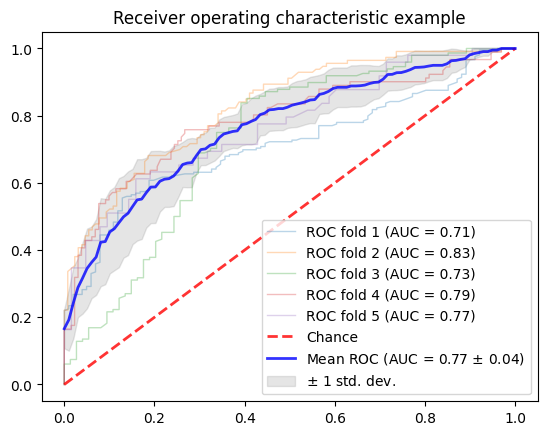

[0.999999944817477, 0.9999898894890625, 0.9584355707126233, 0.999741974432153, 0.999421640791968]
BEDROC: 0.992 +/- 0.017


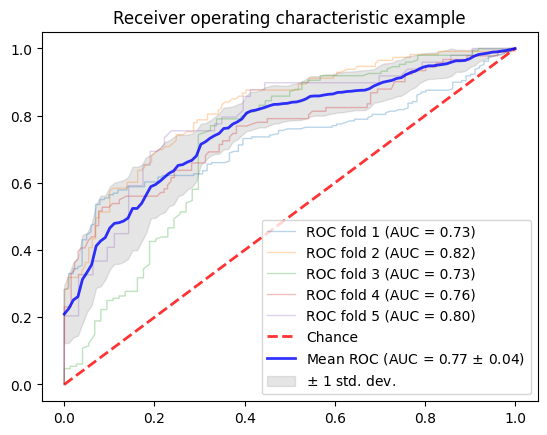

[0.9999999751696861, 0.9999940987236846, 0.9642769814818704, 0.9992964308956411, 0.9966017116355494]
BEDROC: 0.992 +/- 0.014


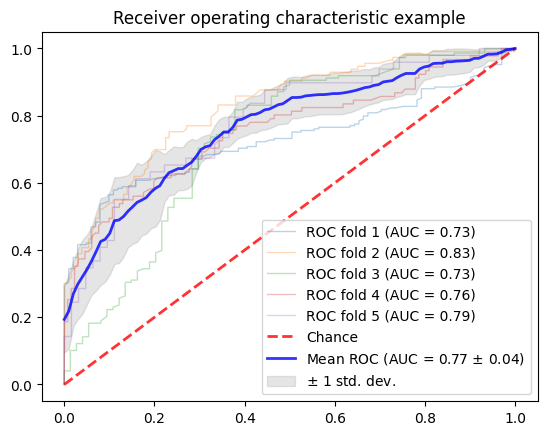

[0.9999995928953593, 0.9999856219630914, 0.982657623558699, 0.9995729921403128, 0.999191283140397]
BEDROC: 0.996 +/- 0.007


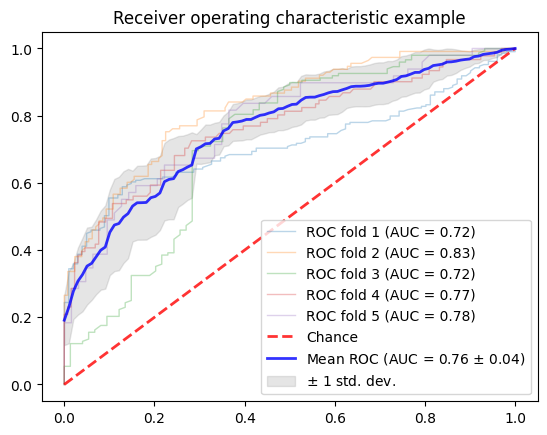

[0.9999991572775612, 0.9999490452076354, 0.9914471592815308, 0.9977293256014372, 0.9983222727777781]
BEDROC: 0.997 +/- 0.003


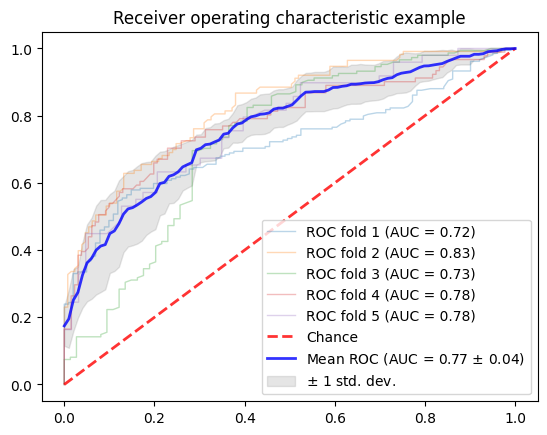

In [29]:
max_features_list = [None, 'sqrt', 0.2, 0.4, 0.8]
for max_features in max_features_list:
    roc_cv(X,y)

### combine the folds and train with best hyperparameter

In [29]:
#80% model, with max_features=0.8 as the best hyperparamter
X = np.array(desc_cols)
y = np.array(subset1.y_ture_lable)
model_0 = RandomForestClassifier(n_estimators=1000,class_weight='balanced', max_features=0.8, 
                                        min_samples_split=2, random_state=42).fit(X, y)

In [30]:
#80% model, with max_features=0.8 as the best hyperparamter, add smote
sm = SMOTE(random_state = 42)
X, y = sm.fit_resample(X,y)
model_00 = RandomForestClassifier(n_estimators=1000,class_weight='balanced', max_features=0.8, 
                                        min_samples_split=2, random_state=42).fit(X, y)

In [31]:
# test with 20% test set
desc_cols2 = subset2.iloc[:, 6:214]
X = np.array(desc_cols2)
y = np.array(subset2.y_ture_lable)

BEDROC: 1.000


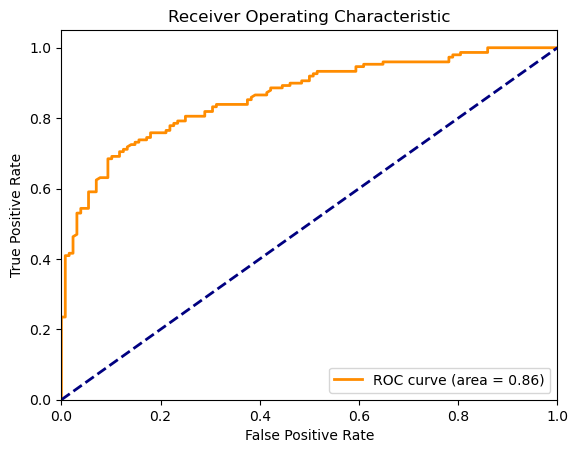

In [32]:
#model_0
# Predict probabilities for the test data
y_scores = model_0.predict_proba(X)[:, 1]

# Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y, y_scores)

# Compute AUC
roc_auc = auc(fpr, tpr)

#bedroc
score = list(zip(y_scores, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score = CalcBEDROC(score, 1, 80.5)
print("BEDROC: {:.3f}".format(bedroc_score))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



BEDROC: 1.000


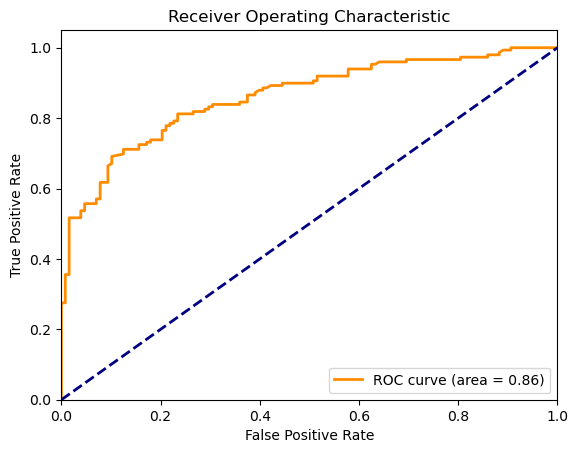

In [34]:
## model_00 (with smote)
# Predict probabilities for the test data
y_scores = model_00.predict_proba(X)[:, 1]

# Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y, y_scores)

# Compute AUC
roc_auc = auc(fpr, tpr)

#bedroc
score = list(zip(y_scores, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score = CalcBEDROC(score, 1, 80.5)
print("BEDROC: {:.3f}".format(bedroc_score))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
## the smote moedl has same performance as the original model

In [45]:
# combine train and test set and train the final model with full dataset
fullset = pd.concat([subset1, subset2], ignore_index=True)
desc_cols3 = fullset.iloc[:, 6:214]
X = np.array(desc_cols3)
y = fullset.y_ture_lable

In [46]:
combined_model = RandomForestClassifier(n_estimators=1000,class_weight='balanced', max_features=0.8, 
                                        min_samples_split=2, random_state=42).fit(X, y)
joblib.dump(combined_model, f'./pretrained_models/chembl_rdkit2D_maxfeatures_0.8_fullset.joblib')

['./pretrained_models/chembl_rdkit2D_maxfeatures_0.8_fullset.joblib']

In [47]:
#X, y = sm.fit_resample(X,y)
#combined_model = RandomForestClassifier(n_estimators=1000,class_weight='balanced', max_features=0.8, 
#                                        min_samples_split=2, random_state=42).fit(X, y)
#joblib.dump(combined_model, f'./pretrained_models/chembl_rdkit2D_maxfeatures_0.8_fullset_smote.joblib')

['./pretrained_models/chembl_rdkit2D_maxfeatures_0.8_fullset_smote.joblib']

## ECFP4 models

### cross validation

In [36]:
morgan2_cols = ['morgan2_b'+str(i) for i in list(range(2048))]
X = subset1[morgan2_cols]
y = subset1.y_ture_lable

[0.9999978893725744, 0.9999967486290073, 0.9272323392813855, 0.8496533890834476, 0.9859029641412614]
BEDROC: 0.953 +/- 0.058


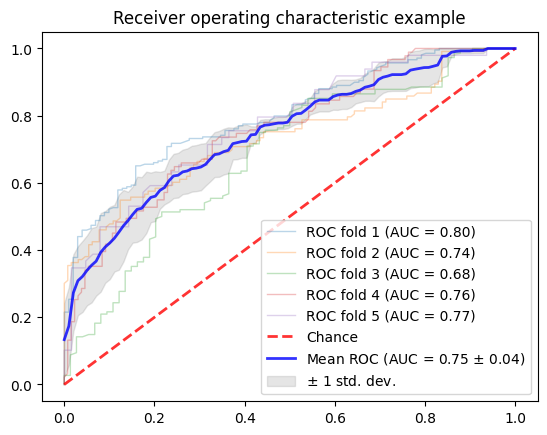

[0.9999999819713881, 0.9999997862338426, 0.8790597129104483, 0.9999949397154919, 0.999785454641801]
BEDROC: 0.976 +/- 0.048


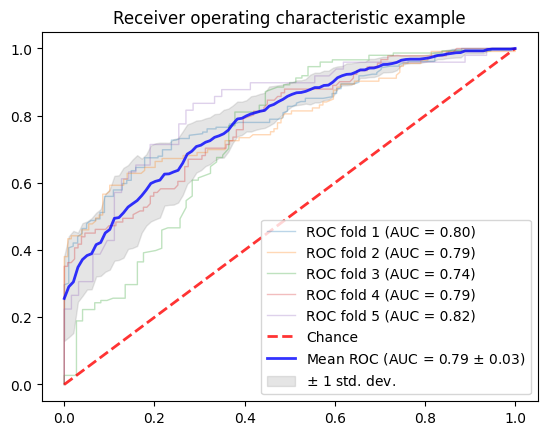

[0.9999999997843232, 0.9999990364268817, 0.8470820685861353, 0.9998745478407174, 0.9983521371597958]
BEDROC: 0.969 +/- 0.061


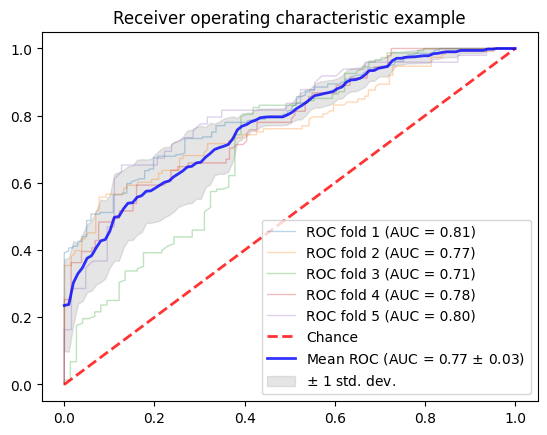

[0.9999999997371326, 0.9999982554084685, 0.8470107041015147, 0.9990114495843616, 0.9966411027594723]
BEDROC: 0.969 +/- 0.061


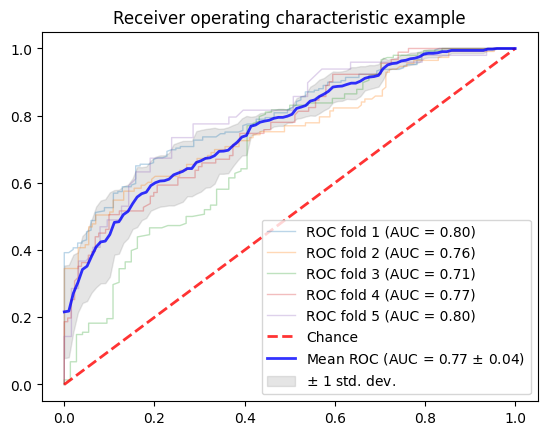

[0.9999999994970384, 0.9999968294848695, 0.8524547717065734, 0.9927238951449177, 0.9931273972319759]
BEDROC: 0.968 +/- 0.058


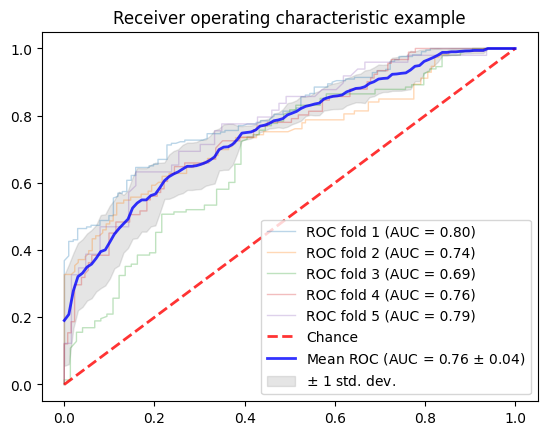

In [39]:
max_features_list = [None, 'sqrt', 0.2, 0.4, 0.8]
for max_features in max_features_list:
    roc_cv(np.array(X),np.array(y))

### combine the folds and train with best hyperparameter

In [37]:
#80% model, with max_features=sqrt as the best hyperparamter
X = subset1[morgan2_cols]
y = subset1.y_ture_lable
model_1 = RandomForestClassifier(n_estimators=1000,class_weight='balanced', max_features='sqrt', 
                                        min_samples_split=2, random_state=42).fit(np.array(X),np.array(y))

In [38]:
#80% model, with max_features=sqrt as the best hyperparamter
sm = SMOTENC(categorical_features=[0,1],random_state = 42) 
X, y = sm.fit_resample(X,y)
model_11 = RandomForestClassifier(n_estimators=1000,class_weight='balanced', max_features='sqrt', 
                                        min_samples_split=2, random_state=42).fit(np.array(X),np.array(y))

In [39]:
#test with 20% test set
X = np.array(subset2[morgan2_cols])
y = subset2.y_ture_lable

[(1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (0.999, 1.0), (0.999, 1.0), (0.999, 1.0), (0.999, 1.0), (0.998, 1.0), (0.998, 1.0), (0.998, 1.0), (0.998, 1.0), (0.997, 1.0), (0.995, 1.0), (0.994, 1.0), (0.994, 1.0), (0.994, 1.0), (0.993, 1.0), (0.992, 1.0), (0.992, 1.0), (0.991, 1.0), (0.991, 1.0), (0.99, 1.0), (0.987, 1.0), (0.985, 1.0), (0.984, 1.0), (0.984, 1.0), (0.983, 1.0), (0.982, 1.0), (0.98, 1.0), (0.98, 1.0), (0.979, 1.0), (0.978, 1.0), (0.976, 1.0), (0.975, 0.0), (0.971, 1.0), (0.97, 1.0), (0.97, 1.0), (0.963, 1.0), (0.963, 1.0), (0.961, 1.0), (0.957, 1.0), (0.957, 1.0), (0.956, 1.0), (0.954, 1.0), (0.952, 1.0), (0.951, 1.0), (0.95, 1.0), (0.9492898719441211, 1.0), (0.948, 1.0), (0.947, 1.0), (0.945, 1.0), (0.942, 1.0), (0.94, 1.0), (0.939, 1.0), (0.937, 1.0), (0.931, 1.0), (0.928, 1.0), (0.926, 1.0), (0.914, 1.0), (0.914, 1.0), (0.905, 1.0), (0.905, 0.0), (0.903, 1.0), (0.898, 0.0), (0.895, 1.0), (0.886, 1.0), (0.883, 1.0), (0.87, 1.0), (0.868, 1.0), (0.86, 1.0), (0.857, 1.0), (0.856,

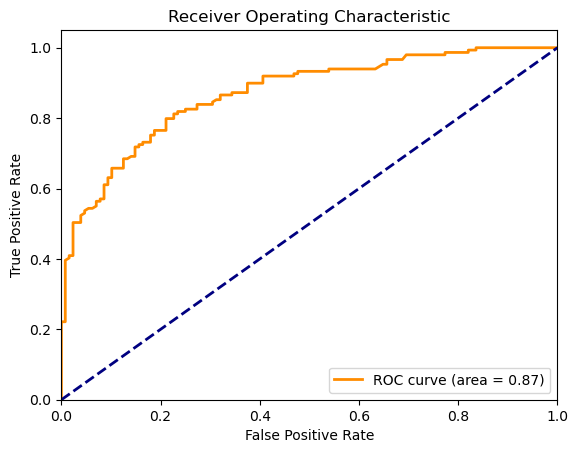

In [40]:
# Predict probabilities for the test data
y_scores = model_1.predict_proba(X)[:, 1]

# Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y, y_scores)

# Compute AUC
roc_auc = auc(fpr, tpr)

#bedroc
score = list(zip(y_scores, y))
score.sort(key=lambda x: x[0], reverse=True)
print(score)
bedroc_score = CalcBEDROC(score, 1, 80.5)
print("BEDROC: {:.3f}".format(bedroc_score))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


BEDROC: 1.000


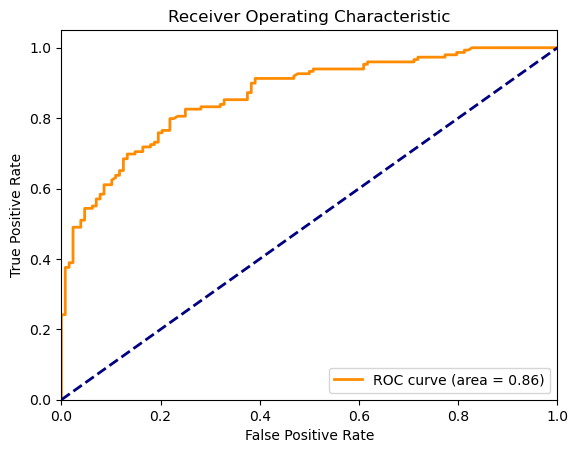

In [41]:
# Predict probabilities for the test data
y_scores = model_11.predict_proba(X)[:, 1]

# Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y, y_scores)

# Compute AUC
roc_auc = auc(fpr, tpr)

#bedroc
#score = list(zip(y_prob, y[test]))
score = list(zip(y_scores, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score = CalcBEDROC(score, 1, 80.5)
print("BEDROC: {:.3f}".format(bedroc_score))

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [42]:
# combine train and test set and train the final model with full dataset
X = fullset[morgan2_cols]
y = fullset.y_ture_lable

In [43]:
combined_model = RandomForestClassifier(n_estimators=1000,class_weight='balanced', max_features='sqrt', 
                                        min_samples_split=2, random_state=42).fit(X, y)
joblib.dump(combined_model, f'./pretrained_models/chembl_morgan2_maxfeatures_sqrt_fullset.joblib')

['./pretrained_models/chembl_morgan2_maxfeatures_sqrt_fullset.joblib']

In [44]:
sm = SMOTENC(categorical_features=[0,1],random_state = 42) 
X, y = sm.fit_resample(X,y)
combined_model = RandomForestClassifier(n_estimators=1000,class_weight='balanced', max_features='sqrt', 
                                        min_samples_split=2, random_state=42).fit(X, y)
joblib.dump(combined_model, f'./pretrained_models/chembl_morgan2_maxfeatures_sqrt_fullset_smote.joblib')

['./pretrained_models/chembl_morgan2_maxfeatures_sqrt_fullset_smote.joblib']

## plot for tow models together

In [ ]:
# plot the roc curve of the 20% chembl test set on the two models trained with 80% training set
X = np.array(desc_cols2)
y = subset2.y_ture_lable

# Predict probabilities for the test data with Model 1
y_scores_model_1 = model_0.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_1, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score1 = CalcBEDROC(score, 1, 80.5)

# Compute ROC metrics for Model 1
fpr_model_1, tpr_model_1, _ = roc_curve(y, y_scores_model_1)
roc_auc_model_1 = auc(fpr_model_1, tpr_model_1)

X = np.array(subset2[morgan2_cols])
y = subset2.y_ture_lable


# Predict probabilities for the test data with Model 2
y_scores_model_2 = model_1.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_2, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score2 = CalcBEDROC(score, 1, 80.5)

# Compute ROC metrics for Model 2
fpr_model_2, tpr_model_2, _ = roc_curve(y, y_scores_model_2)
roc_auc_model_2 = auc(fpr_model_2, tpr_model_2)


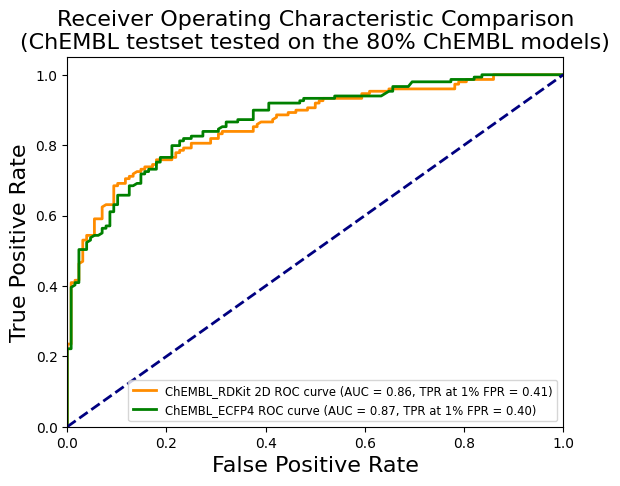

In [64]:
# Calculate TPR at 1% FPR for both models
tpr_at_1_fpr_model_1 = tpr_at_fpr(fpr_model_1, tpr_model_1)
tpr_at_1_fpr_model_2 = tpr_at_fpr(fpr_model_2, tpr_model_2)

# Update the labels to include the early ROC 1% value
label_model_1 = f'ChEMBL_RDKit 2D ROC curve (AUC = {roc_auc_model_1:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_1:.2f})'
label_model_2 = f'ChEMBL_ECFP4 ROC curve (AUC = {roc_auc_model_2:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_2:.2f})'

# Plot the ROC curves
plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, label=label_model_1)
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, label=label_model_2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic Comparison\n(ChEMBL testset tested on the 80% ChEMBL models)', fontsize=16)
plt.legend(loc="lower right", fontsize='small')
plt.show()

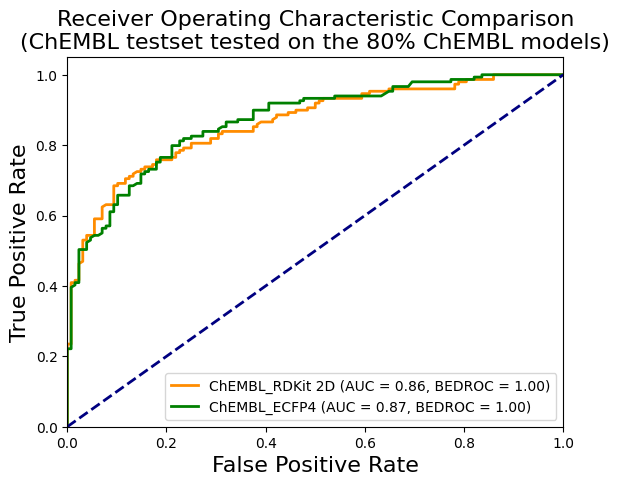

In [65]:
### bedroc version
bedroc_score_model_1 = bedroc_score1
bedroc_score_model_2 = bedroc_score2

plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, 
         label=f'ChEMBL_RDKit 2D (AUC = {roc_auc_model_1:.2f}, BEDROC = {bedroc_score_model_1:.2f})')
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, 
         label=f'ChEMBL_ECFP4 (AUC = {roc_auc_model_2:.2f}, BEDROC = {bedroc_score_model_2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic Comparison\n(ChEMBL testset tested on the 80% ChEMBL models)', fontsize=16)
plt.legend(loc="lower right")
plt.show()

## test chembl models (without smote) with pubchem dataset

In [5]:
# test the full set models with external test set (full set pubchem)
model_2 = joblib.load('./pretrained_models/chembl_rdkit2D_maxfeatures_0.8_fullset_noscaler.joblib')
model_3 = joblib.load('./pretrained_models/chembl_morgan2_maxfeatures_sqrt_fullset.joblib')

In [6]:
pubchem_testset1 = pd.read_csv('./datasets/3_train_test_split/pubchem_testset_featurized.csv')
pubchem_testset2 = pd.read_csv('./datasets/3_train_test_split/pubchem_trainset_featurized.csv')

In [7]:
pubchem_testset = pd.concat([pubchem_testset1, pubchem_testset2], ignore_index=True)

In [8]:
desc_cols4 = pubchem_testset.iloc[:, 6:214]

### Ploting roc curves

In [14]:
X = np.array(desc_cols4)
y = pubchem_testset.y_ture_lable

# Predict probabilities for the test data with Model 1
y_scores_model_1 = model_2.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_1, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score1 = CalcBEDROC(score, 1, 80.5)


# Compute ROC metrics for Model 1
fpr_model_1, tpr_model_1, _ = roc_curve(y, y_scores_model_1)
roc_auc_model_1 = auc(fpr_model_1, tpr_model_1)

X = np.array(pubchem_testset[morgan2_cols])
y = pubchem_testset.y_ture_lable


# Predict probabilities for the test data with Model 2
y_scores_model_2 = model_3.predict_proba(X)[:, 1]

# compute bedroc
score = list(zip(y_scores_model_2, y))
score.sort(key=lambda x: x[0], reverse=True)
bedroc_score2 = CalcBEDROC(score, 1, 80.5)

# Compute ROC metrics for Model 2
fpr_model_2, tpr_model_2, _ = roc_curve(y, y_scores_model_2)
roc_auc_model_2 = auc(fpr_model_2, tpr_model_2)

/home/sliu/miniconda3/envs/mldl/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


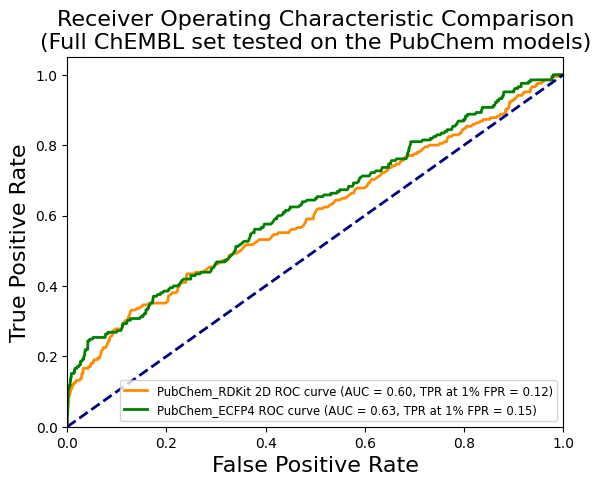

In [15]:
#early ROC version
# Calculate TPR at 1% FPR for both models
tpr_at_1_fpr_model_1 = tpr_at_fpr(fpr_model_1, tpr_model_1)
tpr_at_1_fpr_model_2 = tpr_at_fpr(fpr_model_2, tpr_model_2)
# Update the labels to include the early ROC 1% value
label_model_1 = f'PubChem_RDKit 2D ROC curve (AUC = {roc_auc_model_1:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_1:.2f})'
label_model_2 = f'PubChem_ECFP4 ROC curve (AUC = {roc_auc_model_2:.2f}, TPR at 1% FPR = {tpr_at_1_fpr_model_2:.2f})'

# Plot the ROC curves
plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, label=label_model_1)
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, label=label_model_2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic Comparison\n(Full ChEMBL set tested on the PubChem models)', fontsize=16)
plt.legend(loc="lower right", fontsize='small')
plt.show()

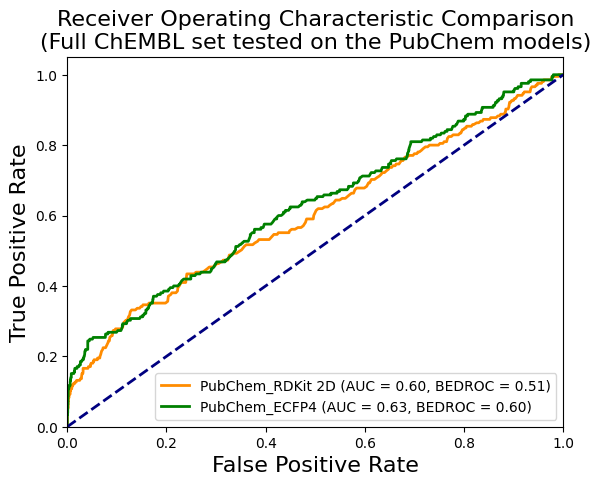

In [16]:
### bedroc version
bedroc_score_model_1 = bedroc_score1
bedroc_score_model_2 = bedroc_score2

plt.figure()
plt.plot(fpr_model_1, tpr_model_1, color='darkorange', lw=2, 
         label=f'PubChem_RDKit 2D (AUC = {roc_auc_model_1:.2f}, BEDROC = {bedroc_score_model_1:.2f})')
plt.plot(fpr_model_2, tpr_model_2, color='green', lw=2, 
         label=f'PubChem_ECFP4 (AUC = {roc_auc_model_2:.2f}, BEDROC = {bedroc_score_model_2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic Comparison\n(Full ChEMBL set tested on the PubChem models)', fontsize=16)
plt.legend(loc="lower right")
plt.show()